In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv("/Users/EthanMcElhone/Downloads/data-1.csv") 

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
0,valley floor / meadow,0,0,0.0174,0.0131,0.0108,0.0133,0.0158,0.0144,0.0151,...,0.0237,0.0231,0.0224,0.0246,0.0255,0.0174,0.0234,0.0147,#030B05,#25C77140
1,valley floor / meadow,1,0,0.0180,0.0124,0.0116,0.0143,0.0154,0.0136,0.0151,...,0.0289,0.0275,0.0288,0.0293,0.0286,0.0211,0.0229,0.0176,#040A09,#25C77140
2,valley floor / meadow,2,0,0.0151,0.0150,0.0113,0.0158,0.0167,0.0158,0.0163,...,0.0358,0.0319,0.0355,0.0274,0.0303,0.0232,0.0282,0.0181,#08110B,#25C77140
3,valley floor / meadow,3,0,0.0172,0.0149,0.0095,0.0156,0.0154,0.0169,0.0176,...,0.0310,0.0294,0.0307,0.0238,0.0304,0.0232,0.0247,0.0087,#0C160C,#25C77140
4,valley floor / meadow,4,0,0.0184,0.0149,0.0143,0.0189,0.0174,0.0174,0.0182,...,0.0428,0.0372,0.0407,0.0344,0.0415,0.0287,0.0317,0.0176,#0E180C,#25C77140


In [107]:
land_mapping = {
    'valley floor / meadow': 0,
    'alpine meadow': 1,
    'alpine tundra': 2,
    'veg-scree mix': 3,
    'bare rock': 4,
    'scree / sunlit rock': 5,
    'dark rock': 6,
    'snow / ice': 7
}

df["land_type"] = df["land_type"].map(land_mapping)

In [ ]:
Y = df["land_type"]

X = df.drop(columns = ["land_type", "rgb_hex", "overlay_hex"]) 

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [111]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
Y_all, Y_pred_all, Y_prob_all = [], [], []

gbdt = GradientBoostingClassifier(
    n_estimators = 100,
    learning_rate = 0.15,
    max_depth = 2,
    subsample = 0.7,
    max_features = "sqrt",
    random_state = 42)

for train, value in skf.split(X_train, Y_train):
    Xtr, Xva = X_train.iloc[train], X_train.iloc[value]
    Ytr, Yva = Y_train.iloc[train], Y_train.iloc[value]
    
    gbdt.fit(Xtr, Ytr)
    Y_pred = gbdt.predict(Xva)
    Y_prob = gbdt.predict_proba(Xva)
    
    Y_all.append(Yva)
    Y_pred_all.append(Y_pred)
    Y_prob_all.append(Y_prob)

Y_train_cv = np.concatenate(Y_all)
Y_train_cv_pred = np.concatenate(Y_pred_all)
Y_train_cv_prob = np.vstack(Y_prob_all)

In [112]:
Y_cv = pd.DataFrame({
    "True Training CV": Y_train_cv,
    "Predicted Training CV": Y_train_cv_pred})

Y_cv

,True Training CV,Predicted Training CV
0,2,2
1,1,1
2,4,4
3,0,0
4,6,6
...,...,...
172478,3,3
172479,3,3
172480,2,2
172481,3,3


In [129]:
Y_test = pd.DataFrame(Y_test)

Y_test = Y_test.rename(columns={"land_type": "True Test"})

Y_test["Predicted Test"] = gbdt.predict(X_test)

Y_test

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 220 features, but GradientBoostingClassifier is expecting 10 features as input.

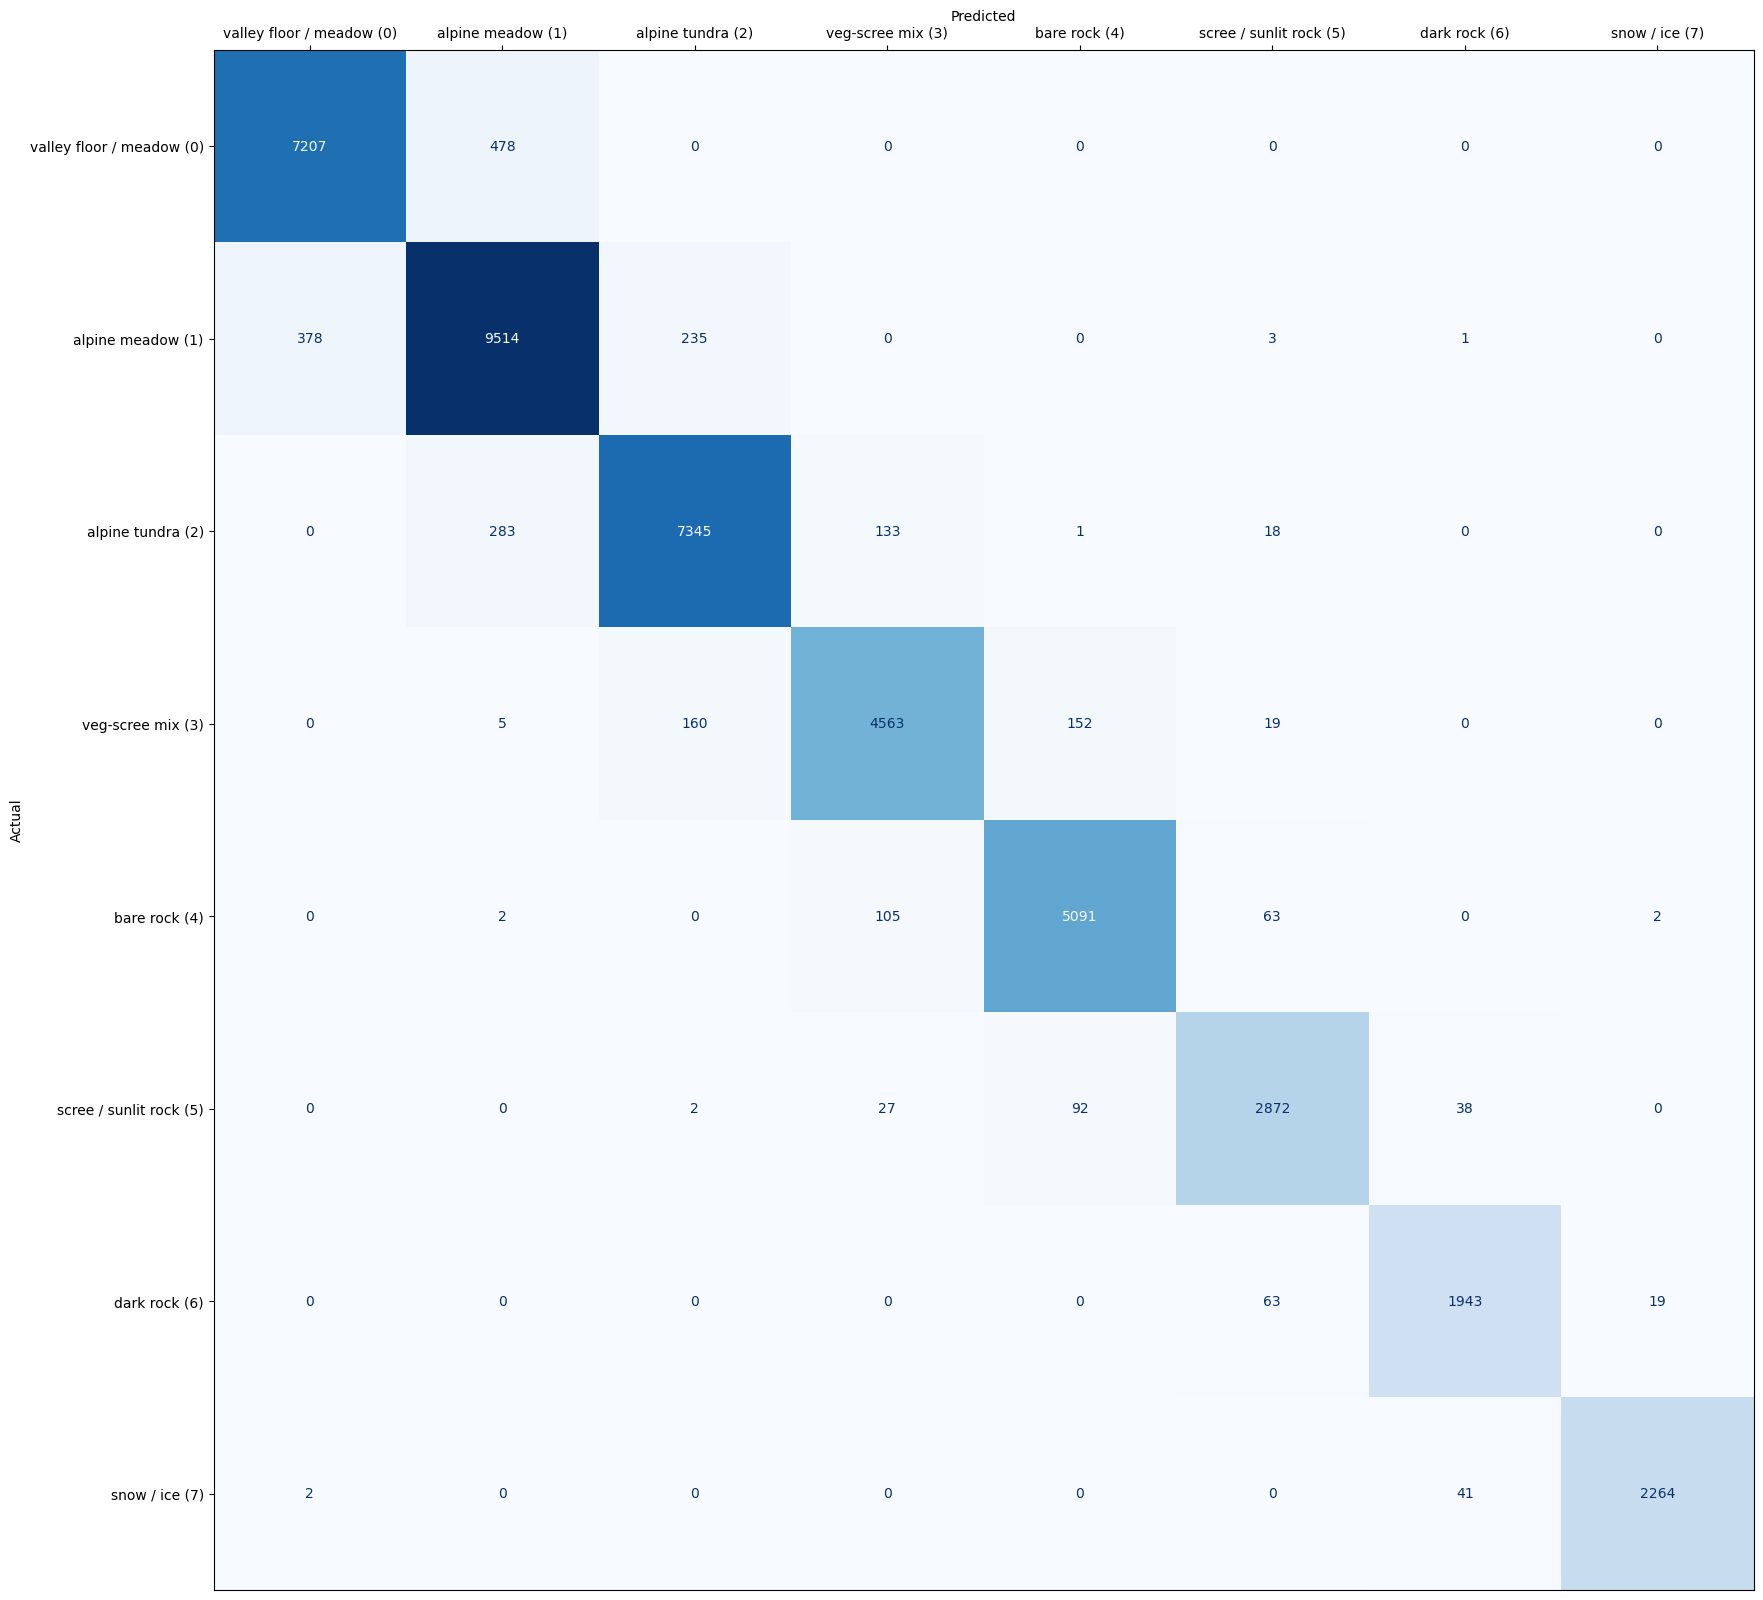

In [ ]:
land_type = ["valley floor / meadow (0)", "alpine meadow (1)", "alpine tundra (2)", "veg-scree mix (3)", 
             "bare rock (4)", "scree / sunlit rock (5)", "dark rock (6)", "snow / ice (7)"]

fig, ax = plt.subplots(figsize=(30, 20))

Confusion_Matrix = ConfusionMatrixDisplay.from_predictions(y_true = Y_test["land_type"],
                                                           y_pred = Y_test["predicted"],
                                                           labels = [0,1,2,3,4,5,6,7],
                                                           display_labels = land_type,
                                                           colorbar = False,
                                                           cmap = "Blues",
                                                           ax = ax)

plt.xlabel("Predicted")
plt.ylabel("Actual")
ax = Confusion_Matrix.ax_
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")
plt.show()

In [ ]:
misclassification = 1 - accuracy_score(Y_test["land_type"], Y_test["predicted"])
print(f"Overall Misclassification Error Rate: {misclassification:4f}")

Overall Misclassification Error Rate: 0.053848


In [ ]:
precision_macro = precision_score(Y_test["land_type"], Y_test["predicted"], average='macro')
print(f"Macro-Average Precision: {precision_macro:.4f}")

precision_weighted = precision_score(Y_test["land_type"], Y_test["predicted"], average='weighted')
print(f"Weighted-Average Precision: {precision_weighted:.4f}")

Macro-Average Precision: 0.9525
Weighted-Average Precision: 0.9462


In [ ]:
recall_macro = recall_score(Y_test["land_type"], Y_test["predicted"], average='macro')
print(f"Macro-Average Recall: {recall_macro:4f}")

recall_weighted = recall_score(Y_test["land_type"], Y_test["predicted"], average='weighted')
print(f"Weighted-Average Recall: {recall_weighted:4f}")

Macro-Average Recall: 0.951016
Weighted-Average Recall: 0.946152


In [ ]:
Y_true = Y_test["land_type"].values
Y_pred = Y_test["predicted"].values
Y_prob = gbdt.predict_proba(X_test) 

balanced_accuracies = []
f1_scores = []
aucs = []

for k in range(8):
    Y_true_k = (Y_true == k).astype(int)
    Y_pred_k = (Y_pred == k).astype(int)
    Y_prob_k = Y_prob[:, k]
    
    balanced_accuracies.append(balanced_accuracy_score(Y_true_k, Y_pred_k))
    f1_scores.append(f1_score(Y_true_k, Y_pred_k))
    aucs.append(roc_auc_score(Y_true_k, Y_prob_k))

avg_balanced_accuracy = np.mean(balanced_accuracies)
avg_f1 = np.mean(f1_scores)
avg_auc = np.mean(aucs)

print(f"Average Balanced Accuracy: {avg_balanced_accuracy:4f}")
print(f"Average F1 Score: {avg_f1:4f}")
print(f"Average AUC: {avg_auc:4f}")

Average Balanced Accuracy: 0.971430
Average F1 Score: 0.951716
Average AUC: 0.998299


In [ ]:
from sklearn.decomposition import PCA

def compute_metrics(model, X_test, Y_test):
    Y_true = Y_test["land_type"].values
    Y_pred = Y_test["predicted"].values
    Y_prob = model.predict_proba(X_test) 

    balanced_accuracies = []
    f1_scores = []
    aucs = []

    for k in range(8):
        Y_true_k = (Y_true == k).astype(int)
        Y_pred_k = (Y_pred == k).astype(int)
        Y_prob_k = Y_prob[:, k]
    
        balanced_accuracies.append(balanced_accuracy_score(Y_true_k, Y_pred_k))
        f1_scores.append(f1_score(Y_true_k, Y_pred_k))
        aucs.append(roc_auc_score(Y_true_k, Y_prob_k))

    return [accuracy_score(Y_true, Y_pred),
        np.mean(balanced_accuracies),
        np.mean(f1_scores),
        np.mean(aucs)]

metrics_raw = compute_metrics(gbdt, X_test, Y_test)

pca = PCA(n_components=10, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

gbdt_pca = gbdt.fit(X_train_pca, Y_train)

metrics_pca = compute_metrics(gbdt_pca, X_test_pca, Y_test)

summary_df = pd.DataFrame(
    [metrics_raw, metrics_pca],
    columns=["Accuracy", "Balanced Accuracy", "F1 Score", "AUC"],
    index=["Raw Features", "PCA (10 components)"])

summary_df

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 220 features, but GradientBoostingClassifier is expecting 10 features as input.